### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

### memo
備忘録
- astropy unitを駆使してわかりやすく書くべき（arcsec/degでバグを増やさないために）
- あらかじめxfftsの分光データをra,dec対応させておく

        
 観測データについて
 - 解析に必要なファイルは？
    - XFFTS分光データ ndf
    - エンコーダ .db
        - あらかじめfk5, galactic に変換して一時ファイルに保存する必要 (npy)
    - weather .???
        - これをどの形式にするか考え中 csv , db
    - 観測時に使用した器差パラメータの入ったファイル hosei_230.txt + alpha
        - これの仕様を早く決定しなくては
        
 これらの複数のファイルをどうやってひとまとめにするか考える必要あり
 - necrecに接続したHDD にndfファイルは保存される
 - その他は全て観測pc
     - nfs mount で観測終了時にHDDにcopyする
     
 - necrec HDD
   - /home/amigos/data/[observation name]/yyyymmhh_HHMMSS/

In [48]:
!ls /home/amigos/data/otf_2019
import time
start_time = time.time()

0727test.db			    otftest_y.db
n20190824043335_12CO_2-1_otf_OriKL  test01.dat
n20190824043539_12CO_2-1_otf_OriKL  test2.db
n20190824043706_12CO_2-1_otf_OriKL  test2.hdf5
n20190824070836_12CO_2-1_otf_OriKL  test3.dat
n20190824071829_12CO_2-1_otf_OriKL  test3.hdf5
n20190824074527_12CO_2-1_otf_OriKL  test4.dat
n20190824075446_12CO_2-1_otf_OriKL  test4.hdf5
n20190824081542_12CO_2-1_otf_OriKL  test5.dat
n20190824082555_12CO_2-1_otf_OriKL  test5.hdf5
n20190824083421_12CO_2-1_otf_OriKL  test6.dat
n20190824094750_12CO_2-1_otf_OriKL  test6.hdf5
n20190828070034_12CO_2-1_otf_OriKL  test.db
n20190829070855_12CO_2-1_otf_OriKL  test.hdf5
n20190903061640_12CO_2-1_otf_OriKL  testwrite.dat
n20190903063123_12CO_2-1_otf_OriKL  testwrite.txt
onepoint_test.db		    write_test.py
otftest.db			    write_test.py~


In [49]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os

In [234]:
#analy_dir = "/home/amigos/data/otf_2019/n20190824043706_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824070836_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824071829_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824074527_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824075446_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824081542_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824083421_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190828070034_12CO_2-1_otf_OriKL"#dcos = y
analy_dir = "/home/amigos/data/otf_2019/n20190829070855_12CO_2-1_otf_OriKL"
analy_dir = "/home/amigos/data/otf_2019/n20190903054835_12CO_2-1_otf_OriKL"#新形式
analy_dir = "/home/amigos/data/otf_2019/n20190903063123_12CO_2-1_otf_OriKL"
analy_dir = "/home/amigos/data/otf_2019/n20190903095549_12CO_2-1_otf_OriKL"
#hosei parameters= 0
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['enc.db',
 'enc.db-journal',
 'hosei_230.txt',
 'otf_test3_dcosy.obs',
 'weather.csv',
 'xffts.ndf']

In [235]:
import log_weather
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)
cabin_temp = weather_data["cabin_temp1"]

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567505e+09  14.517667  16.003498  1.260683  8.340214  268.277438   
1  1.567505e+09  14.768685  16.347520  1.302131  8.638308  268.406670   
2  1.567505e+09  14.587886  16.421841  1.301162  8.568486  268.279324   
3  1.567505e+09  14.409050  16.007638  1.745603  8.590232  268.544346   
4  1.567505e+09  14.353420  15.979677  1.053337  8.548837  268.547030   
5  1.567505e+09  15.076786  15.877779  1.437162  8.505389  268.863282   
6  1.567505e+09  15.239523  16.334328  1.923743  8.797394  268.184209   
7  1.567505e+09  15.034772  15.845336  1.592627  8.822429  268.648550   
8  1.567505e+09  14.986258  16.294985  1.854879  8.940318  268.642462   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  5.961331  570.176709  0.676675    21.648001    31.959803   10.035919   
1  6.306728  570.360962  0.041837    21.971133    32.201503    9.905942   
2  6.205013  570.944504  0.785233    21.9182

In [239]:
%%time
!python /home/amigos/git/analy_n2data/script/analy_coordinates.py  /home/amigos/data/otf_2019/n20190903095549_12CO_2-1_otf_OriKL -p  570.6  -l 1300 -hu  0.0850045489100007 -t          16.364810010118216

/home/amigos/ros/src/necst/lib/n2df.py:63: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('c', '<i')])
Namespace(arg1='/home/amigos/data/otf_2019/n20190903095549_12CO_2-1_otf_OriKL', humi='0.0850045489100007', lamda='1300', press='570.6', temp='16.364810010118216')
100%|███████████████████████████████████| 2033/2033 [00:00<00:00, 384030.81it/s]
2019-09-03 10:05:05 : read_end
2019-09-03 10:05:05 : indexing end
2019-09-03 10:05:05 : hokan
Az [-102.10044611 -102.10056061 -102.10069875 ... -101.95742642 -101.95742642
 -101.95742642]
El [30.29024112 30.28984794 30.2894286  ... 29.48299159 29.48299159
 29.48299159]
[[5368.97810497 5368.97810416 5368.9781033  ... 5368.97646295
  5368.97646295 5368.97646295]
 [6707.84302759 6707.84303062 6707.84303389 ... 6707.84822956
  6707.84822956 6707.84822956]]
16.364810010118216 deg_C
2019-09-03 10:05:08 : coordinate trans end
2019-09-03

In [240]:
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
from scipy import interpolate
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [241]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_to_xffts_c = os.path.join(analy_dir, "xffts_radec.npy")
path_to_encoder_c = os.path.join(analy_dir, "encoder_radec.npy")
xffts = numpy.load(path_to_xffts_c)
encoder = numpy.load(path_to_encoder_c)


### gridの作成


In [242]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read(os.path.join(analy_dir, "otf_test3_dcosy.obs"))
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [243]:
###obsfileの確認
print(lamda_on)
print(beta_on)
print(N)
print(grid)
obsfile_dict

0.80613
-20.37432
9
0.008333333333333333


{'N': 9,
 'acc': 10,
 'beta_off': -20.6683,
 'beta_on': -20.37432,
 'betdel_off': 0,
 'cold_flag': 'N',
 'coordsys': 'j2000',
 'cosydel': 'j2000',
 'datanum': 9.0,
 'end_ch_1': 16383,
 'end_ch_2': 16383,
 'exposure': 0.6,
 'exposure_off': 10.0,
 'fpga_integtime': 100,
 'grid': 30,
 'if1st_freq_1': 4438.0,
 'if1st_freq_2': 5701.3,
 'if3rd_freq_1': 500.0,
 'if3rd_freq_2': 500.0,
 'lambda_off': 0.559,
 'lambda_on': 0.80613,
 'lamdel_off': 0,
 'lamp_pixels': 4,
 'lo1st_sb_1': 'U',
 'lo1st_sb_2': 'L',
 'lo2nd_sb_1': 'L',
 'lo2nd_sb_2': 'L',
 'lo3rd_freq_1': 4100.0,
 'lo3rd_freq_2': 4100.0,
 'lo3rd_sb_1': 'L',
 'lo3rd_sb_2': 'L',
 'load_interval': 5,
 'molecule_1': '12CO',
 'molecule_2': '13CO',
 'multiple': 12,
 'nTest': 1,
 'object': 'OriKL',
 'observer': 'amigos',
 'obsfreq_1': 230538.0,
 'obsfreq_2': 220398.684,
 'obsmode': 'LINEOTF',
 'offset_Az': 0,
 'offset_El': 0,
 'otadel': 'Y',
 'otadel_off': 'Y',
 'otflen': 5.4,
 'otfvel': 50.0,
 'pllharmonic': 1,
 'pllref_if': 1,
 'pllreffreq': 0

In [244]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 20#半径[arcsec]
array_num = 2#1~16IF 

In [245]:
#make gird
ragrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
decgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
radec_grid = numpy.meshgrid(ragrid, decgrid)

In [246]:
print(
beta_on - ((N-1)/2)*grid,
beta_on + ((N-1)/2+1)*grid,
grid)

-20.407653333333336 -20.332653333333333 0.008333333333333333


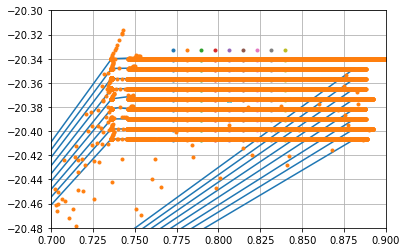

In [247]:
#gridの確認
#girdとXFFTSの点がずれている。これはプロジェクションの問題でcosがかかっていないからか？
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(lamda_on, beta_on, "*")
plt.plot(xffts[0], xffts[1])
plt.plot(encoder[0], encoder[1], ".")
plt.xlim(0.7,0.9)
plt.ylim(-20.48, -20.3)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

### なんで線と点がずれているんだ？

## doppler tracking


In [248]:
#this will be added
from numpy import deg2rad
d = analy_doppler_nanten.doppler_nanten()
vobs = [d.calc_vobs(deg2rad(xffts[0][i]),deg2rad(xffts[1][i]), xffts[2][i]) for i in tqdm(range(len(xffts[0])))]
#vobs = Parallel(n_jobs=-1, verbose=2)([delayed(d.calc_vobs(deg2rad(xffts[0][i]), deg2rad(xffts[1][i]), xffts[2][i])) for i in tqdm(range(len(xffts[0])))])





  0%|          | 0/2033 [00:00<?, ?it/s]



  0%|          | 1/2033 [00:00<04:25,  7.65it/s]



  0%|          | 2/2033 [00:00<04:18,  7.86it/s]



  0%|          | 3/2033 [00:00<04:23,  7.71it/s]



  0%|          | 4/2033 [00:00<04:14,  7.97it/s]



  0%|          | 5/2033 [00:00<04:16,  7.92it/s]



  0%|          | 6/2033 [00:00<04:14,  7.97it/s]



  0%|          | 7/2033 [00:00<04:11,  8.05it/s]



  0%|          | 8/2033 [00:00<04:05,  8.25it/s]



  0%|          | 9/2033 [00:01<04:01,  8.39it/s]



  0%|          | 10/2033 [00:01<03:59,  8.45it/s]



  1%|          | 11/2033 [00:01<03:56,  8.53it/s]



  1%|          | 12/2033 [00:01<04:05,  8.22it/s]



  1%|          | 13/2033 [00:01<04:19,  7.79it/s]



  1%|          | 14/2033 [00:01<04:14,  7.93it/s]



  1%|          | 15/2033 [00:01<04:11,  8.03it/s]



  1%|          | 16/2033 [00:01<04:09,  8.10it/s]



  1%|          | 17/2033 [00:02<04:11,  8.01it/s]



  1%|          | 18/2033 [00:02<04:11,  8.00it/s]



  1%|  

 12%|█▏        | 249/2033 [00:33<04:04,  7.29it/s]



 12%|█▏        | 250/2033 [00:33<04:04,  7.28it/s]



 12%|█▏        | 251/2033 [00:33<04:05,  7.25it/s]



 12%|█▏        | 252/2033 [00:33<04:06,  7.24it/s]



 12%|█▏        | 253/2033 [00:34<04:21,  6.81it/s]



 12%|█▏        | 254/2033 [00:34<04:13,  7.02it/s]



 13%|█▎        | 255/2033 [00:34<04:05,  7.24it/s]



 13%|█▎        | 256/2033 [00:34<04:03,  7.30it/s]



 13%|█▎        | 257/2033 [00:34<03:56,  7.50it/s]



 13%|█▎        | 258/2033 [00:34<03:56,  7.52it/s]



 13%|█▎        | 259/2033 [00:34<04:01,  7.35it/s]



 13%|█▎        | 260/2033 [00:34<03:58,  7.45it/s]



 13%|█▎        | 261/2033 [00:35<03:59,  7.40it/s]



 13%|█▎        | 262/2033 [00:35<04:01,  7.34it/s]



 13%|█▎        | 263/2033 [00:35<03:57,  7.44it/s]



 13%|█▎        | 264/2033 [00:35<03:52,  7.62it/s]



 13%|█▎        | 265/2033 [00:35<03:50,  7.66it/s]



 13%|█▎        | 266/2033 [00:35<03:48,  7.74it/s]



 13%|█▎        | 267/2033 [0

 24%|██▍       | 497/2033 [01:06<03:13,  7.94it/s]



 24%|██▍       | 498/2033 [01:06<03:11,  8.01it/s]



 25%|██▍       | 499/2033 [01:06<03:14,  7.88it/s]



 25%|██▍       | 500/2033 [01:07<03:19,  7.69it/s]



 25%|██▍       | 501/2033 [01:07<03:23,  7.51it/s]



 25%|██▍       | 502/2033 [01:07<03:36,  7.08it/s]



 25%|██▍       | 503/2033 [01:07<03:25,  7.45it/s]



 25%|██▍       | 504/2033 [01:07<03:21,  7.59it/s]



 25%|██▍       | 505/2033 [01:07<03:17,  7.72it/s]



 25%|██▍       | 506/2033 [01:07<03:22,  7.53it/s]



 25%|██▍       | 507/2033 [01:07<03:16,  7.78it/s]



 25%|██▍       | 508/2033 [01:08<03:15,  7.79it/s]



 25%|██▌       | 509/2033 [01:08<03:16,  7.75it/s]



 25%|██▌       | 510/2033 [01:08<03:14,  7.82it/s]



 25%|██▌       | 511/2033 [01:08<03:13,  7.85it/s]



 25%|██▌       | 512/2033 [01:08<03:14,  7.80it/s]



 25%|██▌       | 513/2033 [01:08<03:14,  7.82it/s]



 25%|██▌       | 514/2033 [01:08<03:14,  7.79it/s]



 25%|██▌       | 515/2033 [0

 37%|███▋      | 745/2033 [01:39<02:47,  7.69it/s]



 37%|███▋      | 746/2033 [01:39<02:45,  7.78it/s]



 37%|███▋      | 747/2033 [01:39<02:43,  7.88it/s]



 37%|███▋      | 748/2033 [01:39<02:54,  7.35it/s]



 37%|███▋      | 749/2033 [01:40<02:51,  7.47it/s]



 37%|███▋      | 750/2033 [01:40<02:49,  7.56it/s]



 37%|███▋      | 751/2033 [01:40<02:50,  7.53it/s]



 37%|███▋      | 752/2033 [01:40<02:48,  7.61it/s]



 37%|███▋      | 753/2033 [01:40<02:48,  7.60it/s]



 37%|███▋      | 754/2033 [01:40<02:47,  7.62it/s]



 37%|███▋      | 755/2033 [01:40<02:50,  7.51it/s]



 37%|███▋      | 756/2033 [01:41<03:03,  6.98it/s]



 37%|███▋      | 757/2033 [01:41<03:13,  6.61it/s]



 37%|███▋      | 758/2033 [01:41<03:10,  6.69it/s]



 37%|███▋      | 759/2033 [01:41<03:05,  6.89it/s]



 37%|███▋      | 760/2033 [01:41<02:59,  7.10it/s]



 37%|███▋      | 761/2033 [01:41<02:55,  7.26it/s]



 37%|███▋      | 762/2033 [01:41<02:49,  7.49it/s]



 38%|███▊      | 763/2033 [0

 49%|████▉     | 993/2033 [02:12<02:22,  7.31it/s]



 49%|████▉     | 994/2033 [02:12<02:21,  7.36it/s]



 49%|████▉     | 995/2033 [02:12<02:20,  7.41it/s]



 49%|████▉     | 996/2033 [02:12<02:17,  7.53it/s]



 49%|████▉     | 997/2033 [02:13<02:16,  7.59it/s]



 49%|████▉     | 998/2033 [02:13<02:16,  7.56it/s]



 49%|████▉     | 999/2033 [02:13<02:16,  7.60it/s]



 49%|████▉     | 1000/2033 [02:13<02:14,  7.68it/s]



 49%|████▉     | 1001/2033 [02:13<02:13,  7.72it/s]



 49%|████▉     | 1002/2033 [02:13<02:14,  7.69it/s]



 49%|████▉     | 1003/2033 [02:13<02:12,  7.75it/s]



 49%|████▉     | 1004/2033 [02:13<02:12,  7.79it/s]



 49%|████▉     | 1005/2033 [02:14<02:18,  7.40it/s]



 49%|████▉     | 1006/2033 [02:14<02:16,  7.51it/s]



 50%|████▉     | 1007/2033 [02:14<02:21,  7.26it/s]



 50%|████▉     | 1008/2033 [02:14<02:19,  7.36it/s]



 50%|████▉     | 1009/2033 [02:14<02:16,  7.49it/s]



 50%|████▉     | 1010/2033 [02:14<02:15,  7.57it/s]



 50%|████▉     | 

 61%|██████    | 1237/2033 [02:45<01:44,  7.60it/s]



 61%|██████    | 1238/2033 [02:45<01:49,  7.27it/s]



 61%|██████    | 1239/2033 [02:45<01:49,  7.25it/s]



 61%|██████    | 1240/2033 [02:45<01:48,  7.29it/s]



 61%|██████    | 1241/2033 [02:45<01:45,  7.51it/s]



 61%|██████    | 1242/2033 [02:45<01:42,  7.69it/s]



 61%|██████    | 1243/2033 [02:45<01:42,  7.74it/s]



 61%|██████    | 1244/2033 [02:46<01:42,  7.67it/s]



 61%|██████    | 1245/2033 [02:46<01:45,  7.45it/s]



 61%|██████▏   | 1246/2033 [02:46<01:50,  7.11it/s]



 61%|██████▏   | 1247/2033 [02:46<01:48,  7.24it/s]



 61%|██████▏   | 1248/2033 [02:46<01:45,  7.46it/s]



 61%|██████▏   | 1249/2033 [02:46<01:45,  7.43it/s]



 61%|██████▏   | 1250/2033 [02:46<01:45,  7.45it/s]



 62%|██████▏   | 1251/2033 [02:47<01:43,  7.58it/s]



 62%|██████▏   | 1252/2033 [02:47<01:41,  7.66it/s]



 62%|██████▏   | 1253/2033 [02:47<01:41,  7.66it/s]



 62%|██████▏   | 1254/2033 [02:47<01:49,  7.11it/s]



 62%|█████

 73%|███████▎  | 1481/2033 [03:18<01:18,  7.05it/s]



 73%|███████▎  | 1482/2033 [03:18<01:16,  7.17it/s]



 73%|███████▎  | 1483/2033 [03:19<01:16,  7.15it/s]



 73%|███████▎  | 1484/2033 [03:19<01:21,  6.76it/s]



 73%|███████▎  | 1485/2033 [03:19<01:19,  6.85it/s]



 73%|███████▎  | 1486/2033 [03:19<01:16,  7.14it/s]



 73%|███████▎  | 1487/2033 [03:19<01:13,  7.45it/s]



 73%|███████▎  | 1488/2033 [03:19<01:21,  6.71it/s]



 73%|███████▎  | 1489/2033 [03:19<01:18,  6.93it/s]



 73%|███████▎  | 1490/2033 [03:20<01:17,  7.03it/s]



 73%|███████▎  | 1491/2033 [03:20<01:15,  7.16it/s]



 73%|███████▎  | 1492/2033 [03:20<01:14,  7.28it/s]



 73%|███████▎  | 1493/2033 [03:20<01:13,  7.30it/s]



 73%|███████▎  | 1494/2033 [03:20<01:13,  7.36it/s]



 74%|███████▎  | 1495/2033 [03:20<01:12,  7.39it/s]



 74%|███████▎  | 1496/2033 [03:20<01:13,  7.31it/s]



 74%|███████▎  | 1497/2033 [03:20<01:17,  6.94it/s]



 74%|███████▎  | 1498/2033 [03:21<01:13,  7.25it/s]



 74%|█████

 85%|████████▍ | 1725/2033 [03:51<00:43,  7.11it/s]



 85%|████████▍ | 1726/2033 [03:51<00:42,  7.26it/s]



 85%|████████▍ | 1727/2033 [03:52<00:41,  7.33it/s]



 85%|████████▍ | 1728/2033 [03:52<00:41,  7.37it/s]



 85%|████████▌ | 1729/2033 [03:52<00:40,  7.49it/s]



 85%|████████▌ | 1730/2033 [03:52<00:40,  7.56it/s]



 85%|████████▌ | 1731/2033 [03:52<00:39,  7.55it/s]



 85%|████████▌ | 1732/2033 [03:52<00:41,  7.26it/s]



 85%|████████▌ | 1733/2033 [03:52<00:40,  7.43it/s]



 85%|████████▌ | 1734/2033 [03:53<00:40,  7.33it/s]



 85%|████████▌ | 1735/2033 [03:53<00:41,  7.11it/s]



 85%|████████▌ | 1736/2033 [03:53<00:40,  7.26it/s]



 85%|████████▌ | 1737/2033 [03:53<00:40,  7.37it/s]



 85%|████████▌ | 1738/2033 [03:53<00:40,  7.35it/s]



 86%|████████▌ | 1739/2033 [03:53<00:40,  7.34it/s]



 86%|████████▌ | 1740/2033 [03:53<00:40,  7.18it/s]



 86%|████████▌ | 1741/2033 [03:54<00:41,  7.00it/s]



 86%|████████▌ | 1742/2033 [03:54<00:41,  6.94it/s]



 86%|█████

 97%|█████████▋| 1969/2033 [04:24<00:08,  7.56it/s]



 97%|█████████▋| 1970/2033 [04:24<00:08,  7.43it/s]



 97%|█████████▋| 1971/2033 [04:24<00:08,  7.34it/s]



 97%|█████████▋| 1972/2033 [04:24<00:08,  7.32it/s]



 97%|█████████▋| 1973/2033 [04:25<00:07,  7.51it/s]



 97%|█████████▋| 1974/2033 [04:25<00:08,  7.08it/s]



 97%|█████████▋| 1975/2033 [04:25<00:08,  6.99it/s]



 97%|█████████▋| 1976/2033 [04:25<00:07,  7.22it/s]



 97%|█████████▋| 1977/2033 [04:25<00:07,  7.39it/s]



 97%|█████████▋| 1978/2033 [04:25<00:07,  7.38it/s]



 97%|█████████▋| 1979/2033 [04:25<00:07,  7.49it/s]



 97%|█████████▋| 1980/2033 [04:25<00:06,  7.63it/s]



 97%|█████████▋| 1981/2033 [04:26<00:06,  7.61it/s]



 97%|█████████▋| 1982/2033 [04:26<00:06,  7.73it/s]



 98%|█████████▊| 1983/2033 [04:26<00:07,  6.94it/s]



 98%|█████████▊| 1984/2033 [04:26<00:06,  7.05it/s]



 98%|█████████▊| 1985/2033 [04:26<00:06,  7.19it/s]



 98%|█████████▊| 1986/2033 [04:26<00:06,  7.36it/s]



 98%|█████

In [249]:
numpy.save(os.path.join(analy_dir, "vobs"), vobs)

In [252]:
vobs = numpy.load(os.path.join(analy_dir, "./vobs.npy"))
vobs = numpy.array(vobs)
print(numpy.shape(vobs))
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobsは全て正")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobsは全て負")
else:
    print("vobsは正も負もある")

#config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#ch数の移動
slide_ch = (vobs/dv) - bch#interpolationによる移動量
bch_max = numpy.max(bch)
bch_min = numpy.min(bch)

dp_data = []
xx_data = []
print(numpy.shape(array_data[1]))
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    if vobs[i] >0:
        xx = ch[:-1] - bch[i]
        #yy = new_p[bch[i]:]
        yy = new_p
    elif vobs[i]<0:
        xx = ch[:-1] - bch[i]
        yy = new_p
        #yy = new_p[:bch[i]]
    xx_data.append(xx)
    dp_data.append(yy)
    
print(slide_ch)







  0%|          | 0/2033 [00:00<?, ?it/s]



  1%|▏         | 27/2033 [00:00<00:07, 266.51it/s]

(2033,)
vobsは全て正
(32768,)






  3%|▎         | 64/2033 [00:00<00:06, 288.53it/s]



  5%|▍         | 101/2033 [00:00<00:06, 307.72it/s]



  7%|▋         | 136/2033 [00:00<00:05, 317.57it/s]



  8%|▊         | 170/2033 [00:00<00:05, 323.03it/s]



 10%|█         | 205/2033 [00:00<00:05, 330.40it/s]



 12%|█▏        | 242/2033 [00:00<00:05, 338.25it/s]



 14%|█▎        | 278/2033 [00:00<00:05, 343.40it/s]



 16%|█▌        | 316/2033 [00:00<00:04, 352.59it/s]



 17%|█▋        | 352/2033 [00:01<00:04, 354.23it/s]



 19%|█▉        | 392/2033 [00:01<00:04, 364.96it/s]



 21%|██        | 429/2033 [00:01<00:04, 349.80it/s]



 23%|██▎       | 464/2033 [00:01<00:04, 345.55it/s]



 25%|██▍       | 499/2033 [00:01<00:04, 346.82it/s]



 26%|██▋       | 534/2033 [00:01<00:04, 344.17it/s]



 28%|██▊       | 570/2033 [00:01<00:04, 348.09it/s]



 30%|██▉       | 606/2033 [00:01<00:04, 349.12it/s]



 32%|███▏      | 641/2033 [00:01<00:04, 347.19it/s]



 33%|███▎      | 676/2033 [00:01<00:03, 346.68it/s]



 35%|██

[0.76164566 0.76169113 0.76169792 ... 0.81754991 0.81798712 0.81845654]


In [253]:
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regridの最小値
xx_max = numpy.min(xx_data.T[-1])#regirdの最大値

new_xx = numpy.arange(xx_min, xx_max+1, 1)
print(new_xx, len(new_xx))

[-7.0000e+00 -6.0000e+00 -5.0000e+00 ...  3.2756e+04  3.2757e+04
  3.2758e+04] 32766


In [254]:
mask_list= []
print(numpy.shape(xx_data))
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)

(2033, 32767)


In [255]:
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])





  0%|          | 0/2033 [00:00<?, ?it/s]



 52%|█████▏    | 1048/2033 [00:00<00:00, 10478.51it/s]



100%|██████████| 2033/2033 [00:00<00:00, 10182.96it/s]

In [256]:
len(new_xx)
origin_array_data = array_data
array_data = new_yy_list
len(array_data)
print(len(vobs))

2033


### 分光データの読み出し
on/off/hot indexの整理

In [251]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた





  0%|          | 0/2033 [00:00<?, ?it/s]



  0%|          | 1/2033 [00:00<24:33,  1.38it/s]



  1%|          | 12/2033 [00:00<17:11,  1.96it/s]



  1%|          | 21/2033 [00:00<12:06,  2.77it/s]



  1%|▏         | 30/2033 [00:01<08:32,  3.91it/s]



  2%|▏         | 40/2033 [00:01<06:03,  5.48it/s]



  2%|▏         | 50/2033 [00:01<04:19,  7.64it/s]



  3%|▎         | 63/2033 [00:01<03:05, 10.61it/s]



  4%|▎         | 76/2033 [00:01<02:13, 14.62it/s]



  4%|▍         | 88/2033 [00:01<01:38, 19.82it/s]



  5%|▍         | 99/2033 [00:01<01:14, 26.13it/s]



  5%|▌         | 111/2033 [00:01<00:56, 34.12it/s]



  6%|▌         | 123/2033 [00:01<00:43, 43.44it/s]



  7%|▋         | 135/2033 [00:01<00:35, 52.97it/s]



  7%|▋         | 147/2033 [00:02<00:29, 63.34it/s]



  8%|▊         | 159/2033 [00:02<00:26, 71.21it/s]



  8%|▊         | 170/2033 [00:02<00:23, 79.55it/s]



  9%|▉         | 181/2033 [00:02<00:21, 85.12it/s]



  9%|▉         | 193/2033 [00:02<00:19, 92.22

CPU times: user 368 ms, sys: 300 ms, total: 668 ms
Wall time: 19.1 s


In [257]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

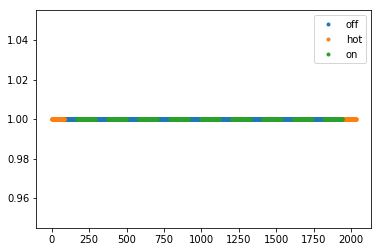

In [258]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
# plt.xlim(0,1000)
plt.legend()
plt.show()

[0 0 0 ... 9 9 9]


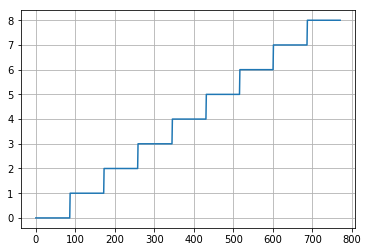

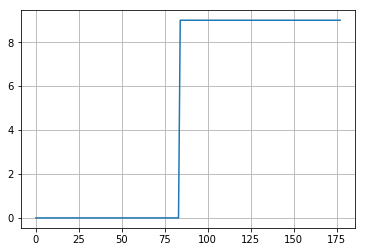

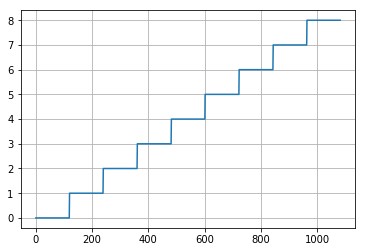

In [259]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [260]:
len(array_data)

2033

In [261]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000





  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 2/2 [00:00<00:00, 193.29it/s]

[0 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952
 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032]


In [262]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))





  0%|          | 0/9 [00:00<?, ?it/s]



100%|██████████| 9/9 [00:00<00:00, 316.91it/s]

[0 1 2 3 4 5 6 7 8]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [263]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)





  0%|          | 0/9 [00:00<?, ?it/s]



100%|██████████| 9/9 [00:00<00:00, 10979.85it/s]

In [264]:
d = numpy.unique(scan_num[offindex[0]])#HOT のscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)





  0%|          | 0/9 [00:00<?, ?it/s]



100%|██████████| 9/9 [00:00<00:00, 12478.92it/s]

In [265]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):    
    #scan_num = n[on_index]["scan_num"]
    #Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deleted（hotdata, offdata[0]しかつかってない！）
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i, cabin_temp[i])] for j in c]###j= index 

In [266]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheelしたやつ





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:01<00:13,  1.52s/it]



 50%|█████     | 5/10 [00:01<00:05,  1.07s/it]



 80%|████████  | 8/10 [00:01<00:01,  1.32it/s]



100%|██████████| 10/10 [00:01<00:00,  5.61it/s]

In [267]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray
data_on[4433][16000] += 100000000
print(data_on[4433][16000])

KeyError: 4433

In [268]:
#距離による重みつけ関数１
#sigma == ビームサイズ
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))


#距離による重みつけ関数2 関数系わからないので今はgaussianだけど修正
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#球面なのでRA方向の長さがDECで変わります。なのでRA-DEC平面での距離(角度)を出すには、RAをcos(DEC)で割る必要があります。
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600#こういうことしなくてもいいようにastropy unitを使う（要編集）
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return ((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5

def calc_rms(arr):
    return numpy.sqrt(numpy.mean(arr**2))

def rms_dist_weighting(arr, dist, rms):
    return [arr*gauss(dist)*(rms**-2), gauss(dist)*(rms**-2)]

## Baseline fitting





  0%|          | 0/1083 [00:00<?, ?it/s]



  3%|▎         | 32/1083 [00:00<00:03, 318.51it/s]

3000 7500 8500 30000






  6%|▌         | 61/1083 [00:00<00:03, 306.42it/s]



  9%|▉         | 97/1083 [00:00<00:03, 318.95it/s]



 12%|█▏        | 132/1083 [00:00<00:02, 325.97it/s]



 15%|█▌        | 167/1083 [00:00<00:02, 332.75it/s]



 19%|█▊        | 203/1083 [00:00<00:02, 336.91it/s]



 22%|██▏       | 238/1083 [00:00<00:02, 338.73it/s]



 25%|██▌       | 272/1083 [00:00<00:02, 336.25it/s]



 28%|██▊       | 304/1083 [00:00<00:02, 314.04it/s]



 31%|███       | 335/1083 [00:01<00:02, 297.82it/s]



 34%|███▎      | 365/1083 [00:01<00:02, 298.19it/s]



 36%|███▋      | 395/1083 [00:01<00:02, 292.21it/s]



 39%|███▉      | 425/1083 [00:01<00:02, 289.59it/s]



 42%|████▏     | 460/1083 [00:01<00:02, 302.84it/s]



 46%|████▌     | 494/1083 [00:01<00:01, 310.78it/s]



 49%|████▊     | 526/1083 [00:01<00:01, 312.78it/s]



 52%|█████▏    | 560/1083 [00:01<00:01, 319.75it/s]



 55%|█████▍    | 593/1083 [00:01<00:01, 321.40it/s]



 58%|█████▊    | 626/1083 [00:01<00:01, 312.19it/s]



 61%|███

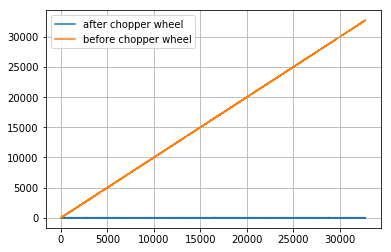

In [269]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, 32766, 32766)###要注意 32768==>32766 一時的

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, 32766, 32766)###要注意 32768==>32766 一時的

for i in tqdm(data_on.keys()):
    data_on[i] = data_on[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = data_on[i]#for debug, this will be deleted
    data_on[i] = baseline_fitting(data_on[i], xindex, index1, index2, index3, index4)
    
    
plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

In [ ]:
#plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
%matplotlib inline
plt.plot(origin-testoffset, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

## grid内のデータ探索

あるgridに採用するデータのindexを求める

In [142]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)






  0%|          | 0/9 [00:00<?, ?it/s]



100%|██████████| 9/9 [00:00<00:00, 91.85it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


### xfftsデータの確認

### データをgridに入れる

本番はもう少し賢く書くけど、ひとまず

In [186]:
%%time
#cubeデータの作成
#data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
#index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？
data_c = numpy.zeros((max_scannum, max_scannum, 32766))#(ra, dec, ch)##要注意！！！
index_list2 = numpy.reshape(index_list, (max_scannum, max_scannum))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータをdatacubeに入れる
for i in tqdm(range(max_scannum)):#ra
    for j in range(max_scannum):#dec
        try:
            numerator_list = []#分子
            denominator_list= []#分母
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                rms = calc_rms(data_on[k])
                weighted_data = rms_dist_weighting(data_on[k], dist, rms)
                #weighted_data = rms_dist_weighting(data_on[k], dist, 1)###RMSがうまく動いているかの確認
                numerator_list.append(weighted_data[0])
                denominator_list.append(weighted_data[1])
            data_c[i][j] = sum(numerator_list)/sum(denominator_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")





  0%|          | 0/9 [00:00<?, ?it/s]



 11%|█         | 1/9 [00:00<00:01,  4.63it/s]



 22%|██▏       | 2/9 [00:00<00:01,  4.59it/s]



 33%|███▎      | 3/9 [00:00<00:01,  4.62it/s]



 44%|████▍     | 4/9 [00:00<00:01,  4.37it/s]



 56%|█████▌    | 5/9 [00:01<00:00,  4.48it/s]



 67%|██████▋   | 6/9 [00:01<00:00,  4.52it/s]



 78%|███████▊  | 7/9 [00:01<00:00,  4.50it/s]



 89%|████████▉ | 8/9 [00:01<00:00,  4.44it/s]



100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

CPU times: user 1.88 s, sys: 4 ms, total: 1.88 s
Wall time: 2.03 s


距離を考慮すると...

### astropyでfitsに書き出す

In [284]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#軸の入れ替えの確認

(32766, 9, 9)


ヘッダーの作成

In [285]:
vch = ch - 16384
crval3 = vch[0]*0.16

header_dict = {
"object": obsfile_dict["object"],
"crval1": obsfile_dict["lambda_on"],
"cdelt1": obsfile_dict["grid"]/3600,
"crpix1": obsfile_dict["N"]-1/2,#中心ピクセル
"crval2": obsfile_dict["beta_on"],
"cdelt2": obsfile_dict["grid"]/3600,
"crpix2": obsfile_dict["N"]-1/2, #中心ピクセル
"cdelt3": 0.16,# km/s 
"crval3": crval3
}

In [286]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    {crval3}                                                  
CDELT3  =    {cdelt3}                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [287]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [288]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto(os.path.join(analy_dir, "test4.fits"), overwrite = True)

In [289]:
##読み込み
hdu_list = fits.open(os.path.join(analy_dir, "test4.fits"))
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

In [290]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

required time : 14655.500931739807


### OTF MAP

In [291]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))

A Jupyter Widget

<function __main__.plot>

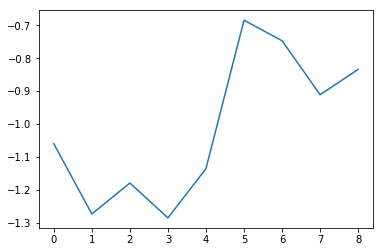

In [346]:
plt.plot(data[7][1])
plt.show()

### RMS Map

In [311]:
#rms map
data_rms = numpy.swapaxes(data, 0,2)

(9, 9, 32766)

In [336]:
numpy.mean(data_rms[0][0]**2)

1.288100482160306

In [314]:
rms_map = numpy.zeros((9,9))
for i in range(9):
    for j in range(9):
        rms_map[i][j] = numpy.sqrt(numpy.mean(data_rms[i][j]**2))

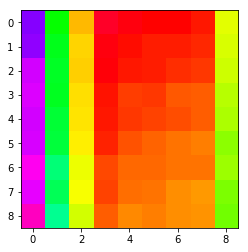

In [315]:
plt.imshow(rms_map, cmap = "gist_rainbow")

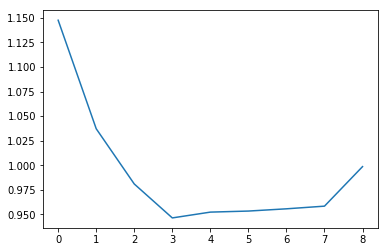

In [312]:
plt.plot(rms_map[4])

In [361]:
len(index_list2[0][8])

119

In [195]:
#bokeh  使い方あんまかしわからん
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()
plt1 = figure()
rend1 = plt1.image(image=[data[16000]], x=0, y=0, dw =31, dh=31, palette="Plasma11")

show(plt1)

Loading BokehJS ...

In [172]:
numpy.max(data)

5.879090403994057

In [173]:
numpy.where(data > 213)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))